**Kalman Filter**

In [ ]:
# import math functions
from math import *
import matplotlib.pyplot as plt
import numpy as np

# gaussian function
def f(mu, sigma2, x):
    ''' f takes in a mean and squared variance, and an input x
       and returns the gaussian value.'''
    coefficient = 1.0 / sqrt(2.0 * pi *sigma2)
    exponential = exp(-0.5 * (x-mu) ** 2 / sigma2)
    return coefficient * exponential

In [ ]:
# the update function
def update(mean1, var1, mean2, var2):
    ''' This function takes in two means and two squared variance terms,
        and returns updated gaussian parameters.'''
    # Calculate the new parameters
    new_mean = (var2*mean1 + var1*mean2)/(var2+var1)
    new_var = 1/(1/var2 + 1/var1)
    
    return [new_mean, new_var]
    
# the motion update/predict function
def predict(mean1, var1, mean2, var2):
    ''' This function takes in two means and two squared variance terms,
        and returns updated gaussian parameters, after motion.'''
    # Calculate the new parameters
    new_mean = mean1 + mean2
    new_var = var1 + var2
    
    return [new_mean, new_var]

In [ ]:
update(20,9,30,3)

[27.5, 2.25]

In [ ]:
# measurements for mu and motions, U
measurements = [5., 6., 7., 9., 10.]
motions = [1., 1., 2., 1., 1.]

# initial parameters
measurement_sig = 4.
motion_sig = 2.
mu = 0.
sig = 10000.


## TODO: Loop through all measurements/motions
# this code assumes measurements and motions have the same length
# so their updates can be performed in pairs
for n in range(len(measurements)):
    # measurement update, with uncertainty
    mu, sig = update(mu, sig, measurements[n], measurement_sig)
    print('Update: [{}, {}]'.format(mu, sig))
    # motion update, with uncertainty
    mu, sig = predict(mu, sig, motions[n], motion_sig)
    print('Predict: [{}, {}]'.format(mu, sig))

    
# print the final, resultant mu, sig
print('\n')
print('Final result: [{}, {}]'.format(mu, sig))

Update: [4.998000799680128, 3.9984006397441023]
Predict: [5.998000799680128, 5.998400639744102]
Update: [5.999200191953932, 2.399744061425258]
Predict: [6.999200191953932, 4.399744061425258]
Update: [6.999619127420922, 2.0951800575117594]
Predict: [8.999619127420921, 4.09518005751176]
Update: [8.999811802788143, 2.0235152416216957]
Predict: [9.999811802788143, 4.023515241621696]
Update: [9.999906177177365, 2.0058615808441944]
Predict: [10.999906177177365, 4.005861580844194]


Final result: [10.999906177177365, 4.005861580844194]


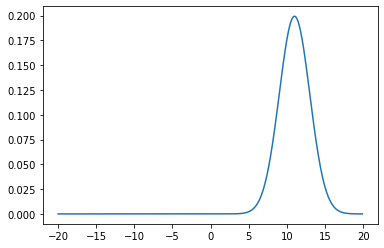

In [ ]:
## Print out and display the final, resulting Gaussian 
# set the parameters equal to the output of the Kalman filter result
mu = mu
sigma2 = sig

# define a range of x values
x_axis = np.arange(-20, 20, 0.1)

# create a corresponding list of gaussian values
g = []
for x in x_axis:
    g.append(f(mu, sigma2, x))

# plot the result 
plt.plot(x_axis, g)

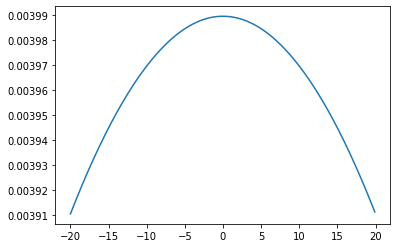

In [ ]:
# display the *initial* gaussian over a range of x values
# define the parameters
mu = 0
sigma2 = 10000

# define a range of x values
x_axis = np.arange(-20, 20, 0.1)

# create a corresponding list of gaussian values
g = []
for x in x_axis:
    g.append(f(mu, sigma2, x))

# plot the result 
plt.plot(x_axis, g)

**MTCNN Face Tracking**

In [ ]:
pip install mmcv
pip install facenet-pytorch
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display


Running on device: cuda:0


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(keep_all=True, device=device)
video = mmcv.VideoReader('/content/facenet-pytorch/examples/vtest1.mov')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 227
Done


In [ ]:
print(boxes)

[[223.4555  188.24289 340.5603  340.6718 ]]


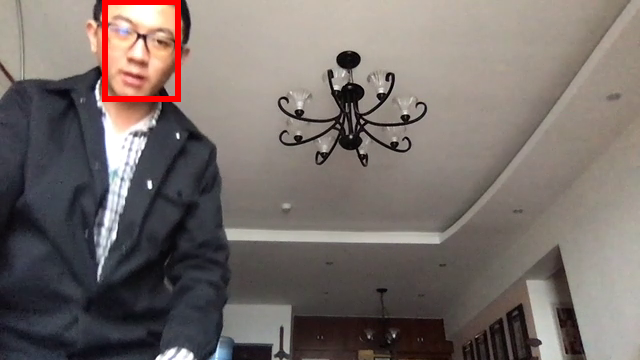

In [ ]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass


**Transfer learing by convnet**

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
!unzip hymenoptera_data.zip

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
visualize_model(model_ft)

plt.ioff()
plt.show()

**MTCNN face recognition Training**

In [ ]:
!unzip WIDER_train.zip

In [ ]:
!ls

 convolutional_neural_network.ipynb   WIDER_train.zip
 Untitled			     'WIDER_train.zip (Unzipped Files)'
 WIDER_train			      WIDER_val.zip


In [ ]:
%cd facenet_pytorch

/content/facenet_pytorch


In [ ]:
%cd ..

/content


In [ ]:
pip install facenet-pytorch

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

In [ ]:
data_dir = '/content/drive/MyDrive/EECE570/WIDER_train/images'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [ ]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

Batch 403 of 403

In [ ]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

In [ ]:

optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()

Google drive


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/foo.txt


Hello Google Drive!

In [ ]:
!ls

drive  sample_data


MTCNN Step by Step

In [2]:
%cd mtcnn-pytorch

/content/mtcnn-pytorch


In [3]:
!git clone https://github.com/TropComplique/mtcnn-pytorch.git

Cloning into 'mtcnn-pytorch'...
remote: Enumerating objects: 76, done.
remote: Total 76 (delta 0), reused 0 (delta 0), pack-reused 76
Unpacking objects: 100% (76/76), done.


In [3]:
import numpy as np
import torch
from PIL import Image
from torch.autograd import Variable

from src.get_nets import PNet, RNet, ONet
from src.box_utils import nms, calibrate_box, get_image_boxes, convert_to_square
from src.first_stage import run_first_stage
from src.visualization_utils import show_bboxes

In [10]:
%ls

doc/  mtcnn/  output/  README.md  scripts/  setup.py  tests/  tutorial/


In [17]:
%rm -r FaceDetector

In [ ]:
!pip install numpy==1.16.1
import numpy as np

In [ ]:
pnet = PNet()
rnet = RNet()
onet = ONet()

In [ ]:
print(pnet)

In [5]:
# if this value is too low the algorithm will use a lot of memory
min_face_size = 15.0  

# for probabilities
thresholds = [0.6, 0.7, 0.8]

# for NMS
nms_thresholds=[0.7, 0.7, 0.7]

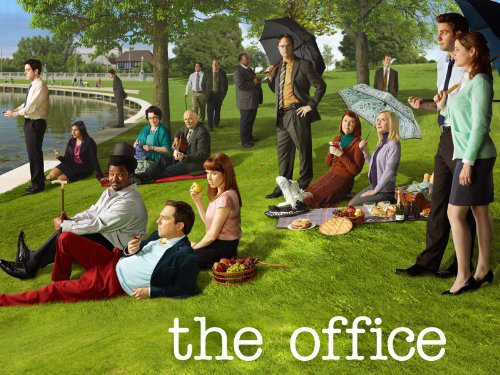

In [6]:
image = Image.open('images/office5.jpg')
image

In [7]:

width, height = image.size
min_length = min(height, width)

min_detection_size = 12
factor = 0.707  # sqrt(0.5)

# scales for scaling the image
scales = []

# scales the image so that
# minimum size that we can detect equals to
# minimum face size that we want to detect
m = min_detection_size/min_face_size
min_length *= m

factor_count = 0
while min_length > min_detection_size:
    scales.append(m*factor**factor_count)
    min_length *= factor
    factor_count += 1

print('scales:', ['{:.2f}'.format(s) for s in scales])
print('number of different scales:', len(scales))

scales: ['0.80', '0.57', '0.40', '0.28', '0.20', '0.14', '0.10', '0.07', '0.05', '0.04']
number of different scales: 10


In [ ]:
bounding_boxes = []

# run P-Net on different scales
for s in scales:
    boxes = run_first_stage(image, pnet, scale=s, threshold=thresholds[0])
    bounding_boxes.append(boxes)

# collect boxes (and offsets, and scores) from different scales
bounding_boxes = [i for i in bounding_boxes if i is not None]
bounding_boxes = np.vstack(bounding_boxes)
print('number of bounding boxes:', len(bounding_boxes))
print(bounding_boxes[0])

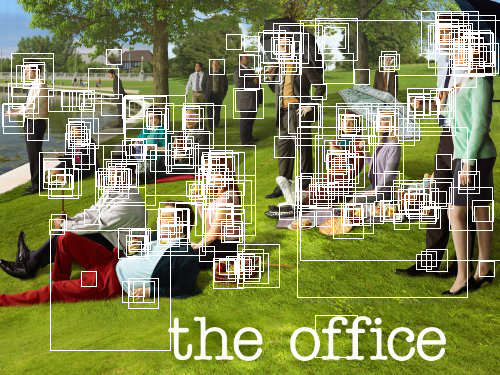

In [13]:
show_bboxes(image, bounding_boxes)

In [14]:
keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0])
bounding_boxes = bounding_boxes[keep]

# use offsets predicted by pnet to transform bounding boxes
bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
# shape [n_boxes, 5]

bounding_boxes = convert_to_square(bounding_boxes)
bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 338


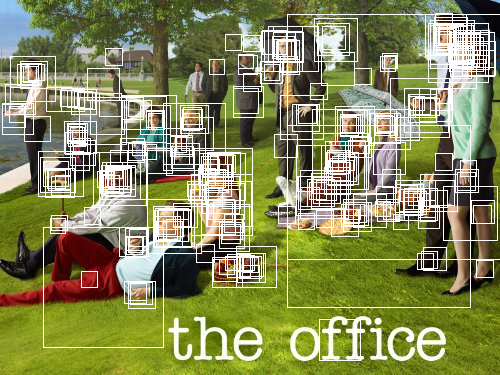

In [15]:
show_bboxes(image, bounding_boxes)

In [17]:
img_boxes = get_image_boxes(bounding_boxes, image, size=24)
img_boxes = Variable(torch.FloatTensor(img_boxes), volatile=True)
output = rnet(img_boxes)
offsets = output[0].data.numpy()  # shape [n_boxes, 4]
probs = output[1].data.numpy()  # shape [n_boxes, 2]

keep = np.where(probs[:, 1] > thresholds[1])[0]
bounding_boxes = bounding_boxes[keep]
bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
offsets = offsets[keep]

print('number of bounding boxes:', len(bounding_boxes))

number of bounding boxes: 71


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/content/mtcnn-pytorch/src/get_nets.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)


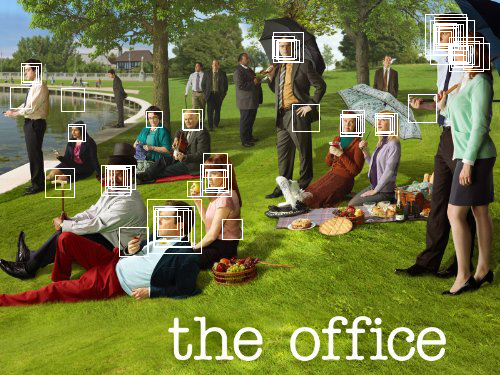

In [18]:
show_bboxes(image, bounding_boxes)

number of bounding boxes: 58


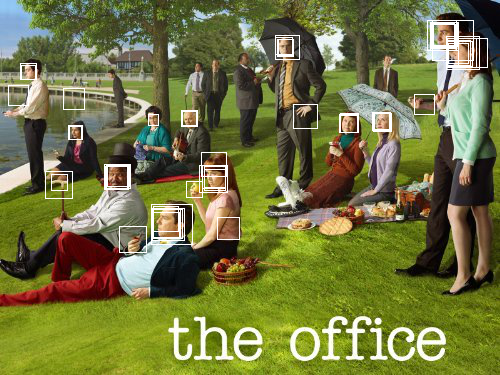

In [19]:
keep = nms(bounding_boxes, nms_thresholds[1])
bounding_boxes = bounding_boxes[keep]
bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
bounding_boxes = convert_to_square(bounding_boxes)
bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
print('number of bounding boxes:', len(bounding_boxes))
show_bboxes(image, bounding_boxes)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/content/mtcnn-pytorch/src/get_nets.py:168: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)


number of bounding boxes: 41


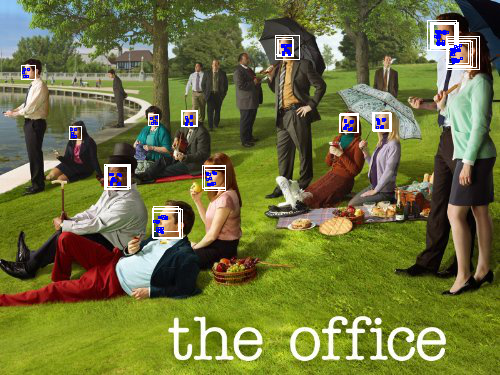

In [20]:
img_boxes = get_image_boxes(bounding_boxes, image, size=48)
img_boxes = Variable(torch.FloatTensor(img_boxes), volatile=True)
output = onet(img_boxes)
landmarks = output[0].data.numpy()  # shape [n_boxes, 10]
offsets = output[1].data.numpy()  # shape [n_boxes, 4]
probs = output[2].data.numpy()  # shape [n_boxes, 2]

keep = np.where(probs[:, 1] > thresholds[2])[0]
bounding_boxes = bounding_boxes[keep]
bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
offsets = offsets[keep]
landmarks = landmarks[keep]

# compute landmark points
width = bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0
height = bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0
xmin, ymin = bounding_boxes[:, 0], bounding_boxes[:, 1]
landmarks[:, 0:5] = np.expand_dims(xmin, 1) + np.expand_dims(width, 1)*landmarks[:, 0:5]
landmarks[:, 5:10] = np.expand_dims(ymin, 1) + np.expand_dims(height, 1)*landmarks[:, 5:10]
    
print('number of bounding boxes:', len(bounding_boxes))

show_bboxes(image, bounding_boxes, landmarks)

number of bounding boxes: 12


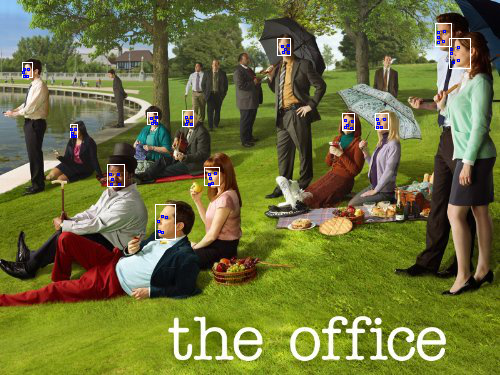

In [21]:

bounding_boxes = calibrate_box(bounding_boxes, offsets)
keep = nms(bounding_boxes, nms_thresholds[2], mode='min')
bounding_boxes = bounding_boxes[keep]
landmarks = landmarks[keep]
print('number of bounding boxes:', len(bounding_boxes))

show_bboxes(image, bounding_boxes, landmarks)

**Train MTCNN**

In [ ]:
!git clone https://github.com/faciallab/FaceDetector.git

In [ ]:
pip install opencv-python numpy easydict Cython progressbar2 torch tensorboardX

In [ ]:
%cd FaceDetector

In [ ]:
!python setup.py install

In [ ]:
!ls

build  doc  mtcnn  output  README.md  scripts  setup.py  tests	tutorial


In [ ]:
import sys
sys.path.append('/content/FaceDetector/mtcnn/network')
import mtcnn_pytorch as mtcnn

In [ ]:
!python setup.py build_ext --inplace

/content/FaceDetector/mtcnn/network/mtcnn_pytorch.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)
/content/FaceDetector/mtcnn/network/mtcnn_pytorch.py:10: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0.1)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


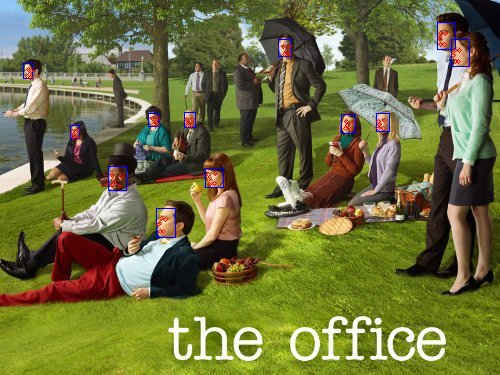

-1

In [ ]:
import cv2
import mtcnn
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# First we create pnet, rnet, onet, and load weights from caffe model.
pnet, rnet, onet = mtcnn.get_net_caffe('output/converted')

# Then we create a detector
detector = mtcnn.FaceDetector(pnet, rnet, onet, device='cuda:0')
img = 'tests/asset/images/office5.jpg'
boxes, landmarks = detector.detect(img)

# Then we draw bounding boxes and landmarks on image
image = cv2.imread(img)
image = mtcnn.utils.draw.draw_boxes2(image, boxes)
image = mtcnn.utils.draw.batch_draw_landmarks(image, landmarks)

# Show the result

cv2_imshow(image)
cv2.waitKey(0)

In [ ]:
!ln -s /content/drive/MyDrive/EECE570/WIDER_train/ mtcnn/datasets/WIDER_FACE/

In [ ]:
!python scripts/gen_pnet_train.py

Traceback (most recent call last):
  File "scripts/gen_pnet_train.py", line 18, in <module>
    landmarks_meta = landmarks_dataset.get_train_meta()
  File "/usr/local/lib/python3.6/dist-packages/mtcnn/datasets/celeba.py", line 88, in get_train_meta
    train, _, _ = self._split()
  File "/usr/local/lib/python3.6/dist-packages/mtcnn/datasets/celeba.py", line 67, in _split
    ret = self._load_all()
  File "/usr/local/lib/python3.6/dist-packages/mtcnn/datasets/celeba.py", line 32, in _load_all
    f_box_anno = open(box_anno)
FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.6/dist-packages/mtcnn/datasets/CelebA/Anno/list_bbox_celeba.txt'


**Fine Tuning Face Recognition**

In [ ]:
!git clone https://github.com/timesler/facenet-pytorch.git
! pip install autocrop
! pip install split-folders
! pip install mmcv
!pip install facenet-pytorch
%cd facenet-pytorch

In [3]:

from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
from models.inception_resnet_v1 import InceptionResnetV1
import cv2, mmcv
from PIL import Image, ImageDraw
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np
import splitfolders
from google.colab.patches import cv2_imshow
import random
import os
import shutil
import operator
from facenet_pytorch import MTCNN
from IPython import display
from keras.models import load_model
from keras.preprocessing import image

In [4]:
%cd data
%cd test

/content/facenet-pytorch/data


In [5]:
!mkdir train_data
!mkdir test
!mkdir sample
!mkdir test_me

In [ ]:
%cd ..

/content/facenet-pytorch/data


In [7]:
%cd test

/content/facenet-pytorch/data/test


In [4]:
%rm -r test
%rm -r sample
%rm -r train_data
%rm -r test_me

rm: cannot remove 'test': No such file or directory
rm: cannot remove 'sample': No such file or directory
rm: cannot remove 'train_data': No such file or directory
rm: cannot remove 'test_me': No such file or directory


In [ ]:
%pwd

'/content/facenet-pytorch/data/test'

In [ ]:
%cd ..
%rm -r test
!mkdir test
%cd test

/content/facenet-pytorch/data
/content/facenet-pytorch/data/test


In [ ]:
vidcap = cv2.VideoCapture('/content/facenet-pytorch/examples/me.mov')
success,image = vidcap.read()
count = 0

while success:
  cv2.imwrite(f"{format(count, '04d')+'a'}.png", image)
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

path = '/content/facenet-pytorch/data/test'
files=os.listdir(path)
d=random.sample(files,100)

for i in d:
  shutil.copy(i,'/content/facenet-pytorch/data/sample')

! autocrop -i /content/facenet-pytorch/data/sample -o /content/facenet-pytorch/data/test_me/1 -r /content/facenet-pytorch/data/reject -w 224 -H 224 --facePercent 80

%cd ..
%rm -r test
%rm -r sample
!mkdir test
!mkdir sample
%cd test

In [ ]:
vidcap = cv2.VideoCapture('/content/facenet-pytorch/examples/me1.mov')
success,image = vidcap.read()
count = 0

while success:
  cv2.imwrite(f"{format(count, '04d')+'b'}.png", image)
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

path = '/content/facenet-pytorch/data/test'
files=os.listdir(path)
d=random.sample(files,100)

for i in d:
  shutil.copy(i,'/content/facenet-pytorch/data/sample')

! autocrop -i /content/facenet-pytorch/data/sample -o /content/facenet-pytorch/data/test_me/2 -r /content/facenet-pytorch/data/reject -w 224 -H 224 --facePercent 80

%cd ..
%rm -r test
%rm -r sample
!mkdir test
!mkdir sample
%cd test

In [ ]:
vidcap = cv2.VideoCapture('/content/facenet-pytorch/examples/me2.mov')
success,image = vidcap.read()
count = 0

while success:
  cv2.imwrite(f"{format(count, '04d')+'c'}.png", image)
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

path = '/content/facenet-pytorch/data/test'
files=os.listdir(path)
d=random.sample(files,100)

for i in d:
  shutil.copy(i,'/content/facenet-pytorch/data/sample')

! autocrop -i /content/facenet-pytorch/data/sample -o /content/facenet-pytorch/data/test_me/3 -r /content/facenet-pytorch/data/reject -w 224 -H 224 --facePercent 80

%cd ..
%rm -r test
%rm -r sample
!mkdir test
!mkdir sample
%cd test

In [11]:
splitfolders.ratio("/content/facenet-pytorch/data/test_me", output="/content/facenet-pytorch/data/train_data", ratio=(.8, .2))

Copying files: 300 files [00:00, 5262.28 files/s]


In [ ]:
!cp -r /content/facenet-pytorch/data/train_data /content/drive/MyDrive/EECE570

^C


In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.45, 0.45, 0.40], [0.23, 0.20, 0.22])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.45, 0.45, 0.40], [0.23, 0.20, 0.22])
    ]),
}
data_dir = '/content/facenet-pytorch/data/train_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=8, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['1', '2', '3']

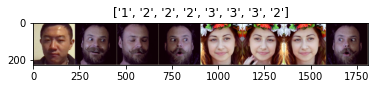

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
from models.inception_resnet_v1 import InceptionResnetV1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

list(model_ft.children())[-6:]
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

for param in model_ft.parameters():
    param.requires_grad = False

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [ ]:
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(layer_list[4].in_features, len(class_names))
model_ft.softmax = nn.Softmax(dim=1)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

In [ ]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=600)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from keras.applications import vgg16

# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Loads the VGG16 model without the top or FC layers
model = vgg16.VGG16(weights='imagenet', include_top = False, input_shape=(img_rows,img_cols,3))

# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

In [ ]:
# Here we freeze the layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

def addTopModel(bottom_model, num_classes, D=256):
    #creates the top or head of the model that will be placed ontop of the bottom layers

    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

# Set the number of classes
num_classes = 3

FC_Head = addTopModel(model, num_classes)

modelnew = Model(inputs = model.input, outputs = FC_Head)

print(modelnew.summary())

In [16]:
from keras_preprocessing.image import ImageDataGenerator

train_data_dir = '/content/facenet-pytorch/data/train_data/train/'
validation_data_dir = '/content/facenet-pytorch/data/train_data/val/'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.4,
      height_shift_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Set the Batch Size according to your system.
train_batchsize = 16
val_batchsize = 10

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [21]:
%cd test

/content/facenet-pytorch/data/test


In [42]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("facedetect.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# We put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
modelnew.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 240
nb_validation_samples = 60

# We only train 7 EPOCHS 
epochs = 7
batch_size = 16

history = modelnew.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

#modelnew.save('facedetect.h5')

Epoch 1/7
15/15 [==============================] - 4s 263ms/step - loss: 0.7557 - accuracy: 0.9292 - val_loss: 4.3710e-08 - val_accuracy: 1.0000
Epoch 2/7
15/15 [==============================] - 4s 238ms/step - loss: 0.0439 - accuracy: 0.9875 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/7
15/15 [==============================] - 4s 237ms/step - loss: 0.1207 - accuracy: 0.9792 - val_loss: 1.7648e-05 - val_accuracy: 1.0000
Epoch 4/7
15/15 [==============================] - 4s 239ms/step - loss: 0.0058 - accuracy: 0.9958 - val_loss: 3.7119e-04 - val_accuracy: 1.0000
Epoch 5/7
15/15 [==============================] - 4s 239ms/step - loss: 0.1537 - accuracy: 0.9625 - val_loss: 2.3827e-04 - val_accuracy: 1.0000
Epoch 6/7
15/15 [==============================] - 4s 237ms/step - loss: 0.0097 - accuracy: 0.9958 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/7
15/15 [==============================] - 4s 238ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_ac

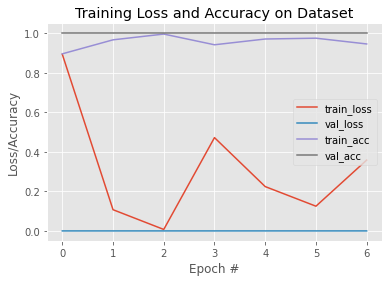

In [37]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("plot.png")

In [29]:
print(modelnew.history)

In [40]:
train_generator.class_indices
modelnew.save('facedetect.h5')


In [ ]:
!cp -r /content/facenet-pytorch/data/facedetect.h5 /content/drive/MyDrive/EECE570

In [41]:
%cd test

/content/facenet-pytorch/data/test


In [ ]:
%cd ..
%rm -r test
!mkdir test
%rm -r video
!mkdir video
%cd test

vidcap = cv2.VideoCapture('/content/facenet-pytorch/examples/vtest1.mov')
success,image = vidcap.read()
count = 0

while success:
  cv2.imwrite(f"{format(count, '04d')+'c'}.png", image)
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

path = '/content/facenet-pytorch/data/test'
files=os.listdir(path)
d=random.sample(files,100)

for i in d:
  shutil.copy(i,'/content/facenet-pytorch/data/video')



In [60]:
%cd frames

/content/facenet-pytorch/data/frames


In [ ]:
%pwd

'/content/facenet-pytorch/data/frames'

In [59]:
!mkdir frames

[[1. 0. 0.]]


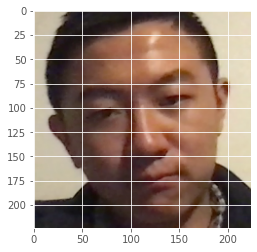

In [49]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

m = load_model("/content/facenet-pytorch/data/facedetect.h5")

#Path to my sample pic
filename = '/content/facenet-pytorch/data/test_me/1/0005a' + '.png'

cimage = image.load_img(filename, target_size=(224,224,3))
plt.imshow(cimage)

cimage = image.img_to_array(cimage)
cimage = np.expand_dims(cimage, axis=0)
result = m.predict(cimage)
print(result)

In [ ]:
%cd ..
%rm -r frames
!mkdir frames
%cd frames
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(keep_all=True, device=device)
start = time.time()
video = mmcv.VideoReader('/content/facenet-pytorch/examples/vtest3.mov')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    label_list = []
    confidence_list = []
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
        cropped = frame.crop((box))
        crop = cropped.resize((224,224))
        cimage = image.img_to_array(crop)
        cimage = np.expand_dims(cimage, axis=0)
        result = m.predict(cimage)
        index = np.argmax(result)
        if index == 0:
          label = 'Kaseya'
        elif index == 1:
          label = 'other'
        elif index == 2:
          label = 'other'
        font = cv2.FONT_HERSHEY_SIMPLEX
        confidence = result[0][index]/np.sum(result)
        label_list.append(label)
        confidence_list.append(confidence)
        # im = np.asarray(frame_draw)
        # cv2.putText(im, str(label)+ '^'+str("{:.2f}".format(confidence)), (box[0],int(box[1]-5)), font, 0.5, (255,0,0), 2)
        # frame_end = Image.fromarray(im.astype('uint8'))
    im = np.asarray(frame_draw)
    for t,index in enumerate(boxes):
      cv2.putText(im, str(label_list[t])+ '^'+str("{:.2f}".format(confidence_list[t])), (boxes[t][0],int(boxes[t][1]-5)), font, 0.5, (255,0,0), 2)
    
        # frame_draw = Image.fromarray(im.astype('uint8')).copy()
        # draw = ImageDraw.Draw(frame_draw)   
    # Add to frame list
    # cv2.imwrite takes in np array only!!!
    cv2.imwrite(f"{format(i, '04d')}.jpg", im)
    frame_end = Image.fromarray(im.astype('uint8'))
    frames_tracked.append(frame_end.resize((640, 360), Image.BILINEAR))
#print(\f'Frames per second: {(i+1)/(time.time() - start):.3f}')
    #     print(f'Frames per second: {(time.time() - start):.3f},',
    #           f'faces detected: {faces_detected}\r',end='')
print('\nDone')

In [75]:
print(label_list)

['Kaseya']


In [74]:
from os.path import isfile, join
pathIn= '/content/facenet-pytorch/data/frames/'
pathOut = 'video1.mp4'
fps = 30
# frame_array = []
# files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

# #for sorting the file names properly
# files.sort(key = lambda x: x[5:-4])
# files.sort()

frame_array = []
files =  os.listdir()
sorted_files =  sorted(files)
#sorted_files.remove('.ipynb_checkpoints')
# files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
# files.sort(key = lambda x: x[5:-4])

for i in range(len(sorted_files)):
    filename=pathIn + sorted_files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

In [ ]:
print(boxes)

[[314.1135  133.23322 436.6776  297.98087]]


In [ ]:
%pwd

'/content/facenet-pytorch/data/frames'

In [ ]:
%cd ..
%rm -r frames
%mkdir frames
%cd frames

/content/facenet-pytorch/data
/content/facenet-pytorch/data/frames


In [ ]:
type(im)

numpy.ndarray

[[1. 0. 0.]]


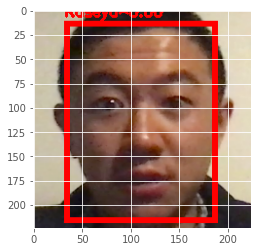

In [79]:
filename = '/content/facenet-pytorch/data/test_me/1/0020a' + '.png'
frame = image.load_img(filename, target_size=(224,224,3))
boxes, _ = mtcnn.detect(frame)

frame_draw = frame.copy()
draw = ImageDraw.Draw(frame_draw)
label_list = []
confidence_list = []
for box in boxes:
    draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    cropped = frame.crop((box))
    crop = cropped.resize((224,224))
    cimage = image.img_to_array(crop)
    cimage = np.expand_dims(cimage, axis=0)
    result = m.predict(cimage)
    index = np.argmax(result)
    if index == 0:
      label = 'Kaseya'
    elif index == 1:
      label = 'guy'
    elif index == 2:
      label = 'girl'
    font = cv2.FONT_HERSHEY_SIMPLEX
    confidence = result[0][1]/np.sum(result)
    print(result)
    label_list.append(label)
    confidence_list.append(confidence)
    #cv2.putText(im, str(label)+ '^'+str("{:.2f}".format(confidence)), (box[0],int(box[1]-5)), font, 0.5, (255,0,0), 2)
    
im = np.asarray(frame_draw)
for i,index in enumerate(boxes):
   cv2.putText(im, str(label_list[i])+ '^'+str("{:.2f}".format(confidence_list[i])), (boxes[i][0],int(boxes[i][1]-5)), font, 0.5, (255,0,0), 2)
frame_end = Image.fromarray(im.astype('uint8'))

plt.imshow(frame_end)


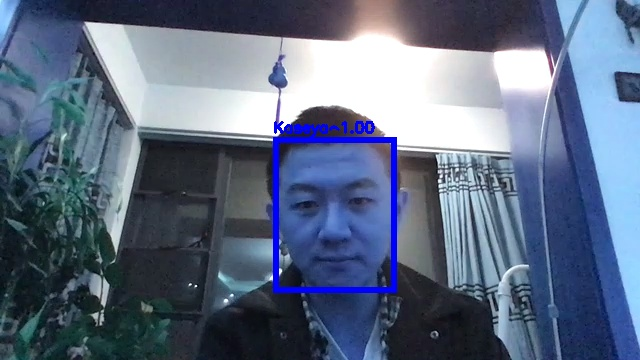

In [106]:
from google.colab.patches import cv2_imshow
filename = '/content/facenet-pytorch/data/frames/0020' + '.jpg'
check = cv2.imread(filename)
cv2_imshow(check)

In [ ]:
print(label_list[1])
print(confidence_list[1])
print(result)

Kaseya
1.0
[[1. 0. 0.]]


In [ ]:
print(boxes[1])

[55.76269 30.8079  85.33751 74.93396]


In [ ]:
files =  os.listdir()
print(files)
sorted_files =  sorted(files)
sorted_files.remove('.ipynb_checkpoints')
print(sorted_files)

Fast MTCNN

In [ ]:
from facenet_pytorch import MTCNN
from PIL import Image
import torch
from imutils.video import FileVideoStream
import cv2
import time
import glob
from tqdm.notebook import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'

filenames = '/content/facenet-pytorch/examples/people.mov'

In [ ]:
print(filenames)

/content/facenet-pytorch/examples/people.mov


In [ ]:
class FastMTCNN(object):
    """Fast MTCNN implementation."""
    
    def __init__(self, stride, resize=1, *args, **kwargs):
        """Constructor for FastMTCNN class.
        
        Arguments:
            stride (int): The detection stride. Faces will be detected every `stride` frames
                and remembered for `stride-1` frames.
        
        Keyword arguments:
            resize (float): Fractional frame scaling. [default: {1}]
            *args: Arguments to pass to the MTCNN constructor. See help(MTCNN).
            **kwargs: Keyword arguments to pass to the MTCNN constructor. See help(MTCNN).
        """
        self.stride = stride
        self.resize = resize
        self.mtcnn = MTCNN(*args, **kwargs)
        
    def __call__(self, frames):
        """Detect faces in frames using strided MTCNN."""
        if self.resize != 1:
            frames = [
                cv2.resize(f, (int(f.shape[1] * self.resize), int(f.shape[0] * self.resize)))
                    for f in frames
            ]
                      
        boxes, probs = self.mtcnn.detect(frames[::self.stride])

        faces = []
        for i, frame in enumerate(frames):
            box_ind = int(i / self.stride)
            if boxes[box_ind] is None:
                continue
            for box in boxes[box_ind]:
                box = [int(b) for b in box]
                faces.append(frame[box[1]:box[3], box[0]:box[2]])
        
        return faces

In [ ]:
fast_mtcnn = FastMTCNN(
    stride=4,
    resize=1,
    margin=14,
    factor=0.6,
    keep_all=True,
    device=device
)

In [ ]:
def run_detection(fast_mtcnn, filenames):
    frames = []
    frames_processed = 0
    faces_detected = 0
    batch_size = 60
    start = time.time()

    for filename in tqdm(filenames):

        v_cap = FileVideoStream(filename).start()
        v_len = int(v_cap.stream.get(cv2.CAP_PROP_FRAME_COUNT))

        for j in range(v_len):

            frame = v_cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            #if len(frames) >= batch_size or j == v_len - 1:
            faces = fast_mtcnn(frames)

            frames_processed += len(frames)
            faces_detected += len(faces)
            frames = []

        print(f'Frames per second: {(time.time() - start):.3f},',
              f'faces detected: {faces_detected}\r',end='')

        v_cap.stop()

run_detection(fast_mtcnn, filenames)

Frames per second: 0.000, faces detected: 0


In [ ]:
b = np.append(boxes_P,boxes_d,axis = 0)
print(b.shape,boxes_P)

In [ ]:
#filter with median filter and show result
ascent = depthFrames[60]
fig = plt.figure()
ax1 = fig.add_subplot(121)  
ax2 = fig.add_subplot(122)
result = ndimage.median_filter(ascent, size=3)
ax1.imshow(ascent)
ax2.imshow(result)

In [ ]:
#need to cd into img file first
#load the image into list in order
%cd img
pathIn= "/content/pyOniExtractor/img/"
depthFrames = []
files =  os.listdir()
sorted_files =  sorted(files)
for i in range(len(sorted_files)):
    filename=pathIn + sorted_files[i]
    #reading each files
    img = cv2.imread(filename)
    img_single = img[:,:,0]
    depthFrames.append(img_single)
%cd ..

In [ ]:
numOfFrames = int(len(depthFrames))
envDepthFrames = depthFrames[:30]
print(len(envDepthFrames))
smoothedEnv = np.zeros(envDepthFrames[0].shape)
for i in range(len(envDepthFrames)):
    img = envDepthFrames[i].astype(np.float32)
    result = ndimage.median_filter(img, size=3)
    smoothedEnv = (smoothedEnv + result)/2
cv2_imshow(smoothedEnv)
print(smoothedEnv[300:450,500:600])

In [ ]:
test = depthFrames[130]
test = ndimage.median_filter(test, size=3)
test = smoothedEnv-test
test = ndimage.median_filter(test, size=3)
test[test<0] = 0
#print(test[100:200,280:320])
#print(np.where(test[100:200,280:320]==np.max(test[100:200,280:320])))

image = Image.fromarray(test.astype('uint8')).convert('RGB')
image_draw = image.copy()
draw = ImageDraw.Draw(image_draw)
threshold = 0.9
R = 200
fw = 2210
fy = 2210
w = R/D*fw
h = R/D*fy
t_std = 3.783282046500663
t_ratio = 0.9535489709982228
'''shape = [(280,200), (350,100)] 
peaks, _ = find_peaks(test[:,359], height=70)
#print(peaks)
peaks1, _ = find_peaks(test[120,:], height=10)
print(peaks1)

#for i in range(len(peaks1)):
index = peaks1[2]
D = test[120,index]*255

boxes_D = []
sum = np.sum(test[120-int(h/2):120+int(h/2),index-int(w/2):index+int(w/2)])
std = np.std(test[120-int(h/2):120+int(h/2),index-int(w/2):index+int(w/2)])
ave = sum/(h*w)
ratio = ave/test[120,index]
print(index,ratio,std)'''
for r in range(test.shape[0]):
  peaks,_ = find_peaks(test[r,:], height = 20)
  for i in range(len(peaks)):
    index = peaks[i]
    D = test[r,index]*255
    w = R/D*fw
    h = R/D*fy
    sum = np.sum(test[r-int(h/2):r+int(h/2),index-int(w/2):index+int(w/2)])
    std = np.std(test[r-int(h/2):r+int(h/2),index-int(w/2):index+int(w/2)])
    ave = sum/(h*w)
    ratio = ave/test[r,index]
    
    # if (ratio) > threshold and std < 10 and std > 3 and w>30 and h>30:
    #   draw.rectangle((index-int(w/2),(r-int(h/2)),(index+int(w/2),(r+int(h/2)))), outline=(255,0,0), width=6)
      
      # print(r,index,ratio,std)
for c in range(test.shape[1]):
  peaks,_ = find_peaks(test[:,c], height = 20)
  for i in range(len(peaks)):
    index = peaks[i]
    D = test[index,c]*255
    w = R/D*fw
    h = R/D*fy
    sum = np.sum(test[index-int(h/2):index+int(h/2),c-int(w/2):c+int(w/2)])
    ave = sum/(h*w)
    ratio = ave/test[index,c]
    # if (ratio) > threshold and std < 10 and std > 3 and w>30 and h>30:
    #   draw.rectangle((c-int(w/2),(index-int(h/2)),(c+int(w/2),index+int(h/2))), outline=(255,0,0), width=6)

# print(D,w,h,fw,fy)
  # sum = np.sum(test[150-int(h/2):150+int(h/2),index-int(w/2):index+int(w/2)])
  # ave = sum/(h*w)
  # ratio = ave/test[150,index]
  # std = np.std(test[150-int(h/2):150+int(h/2),index-int(w/2):index+int(w/2)])
  #print(i,test[150][index],ratio,std)
#draw.rectangle(((275,180), (350,100)), outline=(255,0,0), width=6)

array = np.asarray(image_draw)
plt.imshow(array)

In [ ]:
def removeFar(img,threshold):
    maxVal = np.amax(img)
    print(maxVal)
    ret,output =  cv2.threshold(img, threshold, maxVal,  
                  cv2.THRESH_TOZERO_INV)
    return output

In [ ]:
im = cv2.imread('seq0_0010_0.pgm',-1)
im = np.rot90(im)
fig = plt.figure()
fig.add_subplot(1,3,1)
plt.imshow(im)
im1 = removeFloor(im,9000)
fig.add_subplot(1,3,2)
plt.imshow(im1)
im2 = removeFar(im1,520000)
fig.add_subplot(1,3,3)
plt.imshow(im2)


In [ ]:
def removeFloor(img_array,threshold):
    height = img_array.shape[0]
    width = img_array.shape[1]
    cy = int(height/2)  #center y
    fy = 580  #focal length y
    z = 5000  #initial min depth
 
    croppedRow = img_array[-1][np.nonzero(img_array[-1])]
    if (len(croppedRow)>0):
        z = stats.mode(croppedRow).mode[0]      #initial floor depth
    else:
        z = 75
 
    Y = z*(height-cy)/fy                         #actual y of floor
    Y = Y-threshold
     
    for i in range(height-1,cy-1,-1):
        z1 = (Y*fy)/((i+1)-cy)                   #depth of Y height
 
        for j in range(width):             
            if (img_array[i][j] > z1):
                img_array[i][j] = 0
 
    #output,__ = normalizeImage(img_array)
    return img_array

In [ ]:
depthFrames = cv2.imread('seq0_0069_0.pgm',-1)
envDepthFrames = depthFrames

smoothedEnv = np.zeros(envDepthFrames.T.shape)


#for frameNum in range(q1,q1+10):
img = envDepthFrames.astype(np.float64)
img = np.rot90(img)
maxDepth = np.max(img)
img = img/ np.linalg.norm(img)
floorRemoved = removeFloor(img*255,9)
floorRemoved = floorRemoved/ np.linalg.norm(floorRemoved)
floorRemoved = floorRemoved*maxDepth
distantFiltered = removeFar(floorRemoved,4000)
smoothedEnv = floorRemoved
plt.imshow(floorRemoved)


In [ ]:
 
filelist = glob.glob('/content/*.pgm')
depthFrames = np.array([np.array(Image.open(fname)) for fname in filelist])

env = smoothedEnv
numOfFrames = int(depthFrames.shape[0])
numOfFrames = numOfFrames/2
actionFrameCount = int(numOfFrames)
previousSilhouttePosition = None
lastFrame = None

silhouetteAvailable = True
original = depthFrames[::2][0].astype(np.float64)
original = np.rot90(original)
maxDepth = np.max(original)
normalizedOriginal = original / np.linalg.norm(original)
floorRemoved = removeFloor(normalizedOriginal*255,9) 
floorRemoved = floorRemoved/ np.linalg.norm(floorRemoved)
floorRemoved = floorRemoved * maxDepth
distantFiltered = removeFar(floorRemoved,4000)
foreground = distantFiltered - env
img = foreground.astype(np.float32)/np.linalg.norm(foreground)
ret,binaryImg = cv2.threshold(img,0.005,1,cv2.THRESH_BINARY)
realDepthSilhouette = (binaryImg * normalizedOriginal)

print(realDepthSilhouette[250][200])
plt.imshow(realDepthSilhouette)


In [ ]:
class UFarray:
    def __init__(self):
        self.P = []    # Array which holds label -> set equivalences
        self.label = 0 # Name of the next label, when one is created
    def makeLabel(self):
        r = self.label
        self.label += 1
        self.P.append(r)
        return r
     
    # Makes all nodes "in the path of node i" point to root
    def setRoot(self, i, root):
        while self.P[i] < i:
            j = self.P[i]
            self.P[i] = root
            i = j
        self.P[i] = root
 
    # Finds the root node of the tree containing node i
    def findRoot(self, i):
        while self.P[i] < i:
            i = self.P[i]
        return i
     
    # Finds the root of the tree containing node i
    #Simultaneously compresses the tree
    def find(self, i):
        root = self.findRoot(i)
        self.setRoot(i, root)
        return root
     
    def union(self, i, j):
        if i != j:
            root = self.findRoot(i)
            rootj = self.findRoot(j)
            if root > rootj: root = rootj
            self.setRoot(j, root)
            self.setRoot(i, root)
     
    def flatten(self):
        for i in range(1, len(self.P)):
            self.P[i] = self.P[self.P[i]]

In [ ]:
def get_components(frame, threshold):
    width, height = frame.shape[1], frame.shape[0]
    uf = UFarray()
    labels = {}    # Dictionary of point:label pairs
    print(labels)
    for y, x in itertools.product(range(height),range(width)):
       
       if frame[y, x] == 0:
          pass
       elif (y > 0) and (abs(frame[y-1,x]-frame[y,x]) < threshold):
          labels[y,x] = labels[(y-1),x]
  
       elif x+1 < width and y >0 and (abs(frame[y-1,x+1]-frame[y,x]) < threshold):
          c = labels[(y-1),x+1]
          labels[y,x] = c
  
          if x > 0 and abs(frame[y-1,x-1]-frame[y, x]) < threshold:
              a = labels[(y-1,x-1)]
              uf.union(c, a)
  
          elif x > 0 and abs(frame[y, x-1]-frame[y, x]) < threshold:
              d = labels[(y, x-1)]
              uf.union(c, d)
  
          elif x > 0 and y > 0 and abs(frame[y-1,x-1]-frame[y,x]) <threshold:
              labels[y,x] = labels[(y-1,x-1)]
  
          elif x > 0 and abs(frame[y, x-1]-frame[y, x]) < threshold:
              labels[y, x] = labels[(y, x-1)]
  
          else: 
             labels[y, x] = uf.makeLabel()
   
    uf.flatten()
 
    for (y, x) in labels:
        component = uf.find(labels[(y, x)])
        labels[(y, x)] = component
    return labels

In [ ]:
labels = get_components(realDepthSilhouette,0.3)

In [ ]:
labels = {} 
for y, x in itertools.product(range(3),range(3)):
  print(y,x)
  if y >0 and x>0:
    labels[y,x] = labels[(y-1),x]
  print(labels)